--- 
Microeconometrics | Summer 2021 | M.Sc. Economics, Bonn University 

# Replication of Angrist, J., and Evans, W. (1998). "Children and Their Parent's Labor Supply: Evidence from Exogenous Variation in Family Size". <a class="tocSkip">   

[Carolina Alvarez Garavito](https://github.com/carolinalvarez)
---

**Angrist, J.D., & Evans, W.N. (1998).** [Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size](https://www.jstor.org/stable/116844?seq=1). *The American Economic Review*, 88(3). 450-477. 

# Table of contents
* [Introduction](#Introduction)
* [Identification Strategy](#Identification)
* [Empirical Methodology](#Empirical-Methodology)
* [Replication Angrist & Evans (1998)](#Replication-of-Angrist-&-Evans-(1998))
 * [Data & Descriptive Statistics](#Data-&-Descriptive-Statistics)

In [1]:
%matplotlib inline
#!pip install linearmodels
#!pip install stargazer
#!pip install econml
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
from linearmodels.iv import IV2SLS
import matplotlib as plt
import matplotlib.pyplot as plt
import copy
from IPython.display import HTML
from stargazer.stargazer import Stargazer
from statsmodels.api import add_constant
from functools import reduce
from sklearn.model_selection import train_test_split
from econml.grf import CausalIVForest

In [2]:
from auxiliary.auxiliary_data_preparation import ( 
    data_preparation_1980,
    data_preparation_1990,
    get_data_all_women_1980,
    get_data_all_women_1990,
    data_preparation_married_couples,
    data_preparation_married_couples_1990,
    rename_interactions_earnings,
    families_one_more_kid
)

from auxiliary.auxiliary_statistics import ( 
    table_sum_stats,
    table_sum_stats_husbands, 
    Table_3_panel_1,
    Table_3_panel_2,
    difference_means
)

from auxiliary.auxiliary_plots import ( 
    plot_distribution
)

from auxiliary.auxiliary_regressions import ( 
    OLS_Regressions_more2k,
    OLS_Labor_Supply_Models,
    OLS_Labor_Supply_Interactions_wifes,
    OLS_Labor_Supply_Interactions_husbands,
    OLS_Labor_Supply_First_Stage_wifes,
    OLS_Labor_Supply_First_Stage_husbands,
    IV_Labor_Supply_Interactions,
    mean_samples,
    IV_Comparison_Models,
    mean_differences_instruments,
    mean_differences_instruments_90,
    wald_estimates_regressions
)

---
# Introduction 
---

---
# Identification
--- 
![causal graph1](files/causal_graph_v2.png)


Angrist and Evans (1998) study the causal mechanisms between fertility and the work effort of both men and women. The authors begin by explaining the theoretical and practical reasons of studying the relationship between fertility and labor supply. First, there has been development of economic models that link the family and the labor market. Second, the relationship between fertility and labor supply could explain the increase of women's participation in the labor market in the post-war period, where having fewer children could have increased the female labor-force share. Meanwhile, other studies have linked fertility with female withdraws from the labor market and lower wages compared to men.

The mayority of empirical studies related to childbearing and labor supply find a negative correlation between family size (i.e., fertility) and female labor force. However, in his assesment of Economics of the Family, Robert J. Willis argues that there has not been well-measured exogenous variables that allow to separate cause and effect relationships from correlations among variables such as delay of marriage, decline of childbearing, increase in divorces, and increase in female labor force participation.

In this vein, the authors argue that the problems concerning the causal association between family size and labor supply arises from the theoretical argument that both factors are jointly determinated. For example, some labor-supply econometric models often use child-status variables as regressors on hours of work. On the other hand, economic demographers usually measure the effect of wages on fertility. According to the authors, "*since fertility variables cannot be both dependent and exogenous at the same time, it seems unlikely that either sort of regression has a causal interpretation*". 

Angrist and Evans (1998) contribute by using an **instrumental variable strategy (IV)** based on the sex-mix of children in families with two or more kids. This captures parental preferences for mixed-sex siblings, where parents of same-sex children are much more likely to have an additional child.

**Endogeneity Problem**

<center>Fertility 🠊 Labor supply</center>
<center>Labor supply 🠊 Fertility </center>

**Instrument** 

<center>Dummy variable for whether the sex of the second child matches the sex of the first child</center> 

---
# Empirical Methodology
## Casual estimation with a Binary IV

\begin{equation}
Y = \alpha + \delta D + \epsilon
\end{equation}

\begin{equation}
E[Y] = E[\alpha + \delta D + \epsilon]= \alpha + \delta E[D] + E[\epsilon]
\end{equation}

We re-write it as a difference equation in Z and divide both sides by $ E[D|Z=1] - E[D|Z=0]$ which yields:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\frac{\delta (E[D|Z=1]-E[D|Z=0]) + (E[\epsilon|Z=1]-E[\epsilon|Z=0])}{E[D|Z=1]-E[D|Z=0]}
\end{equation}

If the data holds for the causal graph despicted above, then $Z$ has no association with $ /epsilon$ and therefore:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\delta
\end{equation}

Under these conditions, the ratio of the population-level association between Y and Z and between D and Z is equal to the causal effect of D on Y. Then, if $Z$ is associated with $D$ but not with $/upvarepsilon$, then the following is the IV-Estimator for infinite samples:

\begin{equation}
\hat{\delta}_{IV,WALD} = \frac{E_N[y_i|z_i=1] - E_N[y_i|z_i=0]}{E_N[d_i|z_i=1] - E_N[d_i|z_i=0]}
\end{equation}

This is the IV-Estimator, which is known as the Wald Estimator when the instrument is binary. The wald estimator takes the average difference in the observed outcome of those who were exposed to the instrumental variable and of those who were not. Then it takes the average difference between the ones in the treatment group who took the treatment and those in the tratment group who did not receive the treatment.

## IV Estimation as LATE Estimation

Imbends and Angrist (1994) developed a framework for classifiying individuals as: i) those who respond positively to an instrument; ii) those who remain unaffected by the instrument; iii) those who rebel against the instrument. When $D$ and $Z$ are binary variables, then they are four possible group of individuals:

| Status                                    |Potential treatment assignment         | 
| ------------------------------------------|:-------------------------------------:| 
| Compliers ($\tilde{C}=c$)                 | $D^{Z=0}=0; D^{Z=1}=1$                | 
| Defiers ($\tilde{C}=d$)                   | $D^{Z=0}=1 D^{Z=1}=0$                 | 
| Always takers ($\tilde{C}=a$)             | $D^{Z=0}=1 D^{Z=1}=1$                 |  
| Never takers ($\tilde{C}=n$)              | $D^{Z=0}=0 D^{Z=1}=0$                 |   


A valid instrument $Z$ for the casual effect of $D$ on $Y$ must satisfy three assumptions in order to identify the **LATE**:

* Independence assumption: ($Y^{1}, Y^{0}, D^{Z=1}, D^{Z=0} \indep Z$)

This is analogous to the assumption that $cov(Z, \varepsilon)=0$ in the traditinal IV litera
* Non-zero effect of instrument assumption: $k \neq 0$ for all $i$
* Monotonicity assumption: either $k \geq 0$ for all $i$ or $k \leq 0$ for all $i$ 


---

---
# Replication of Angrist & Evans (1998)
---

## I. Data, Descriptive Statistics and First- Stage Relationships

### A. Data & Descriptive Statistics

Angrist and Evans (1998) use two extracts from the Census Public Use Micro Samples(PUMS) that correspond to the year 1980 and 1990 respectively. The Census contains information on labor supply, the sex of mother's first two children, an indicator of multiple births and other demographic variables.

However, there is no retrospective fertility information in the PUMS data sets other than the total number of children ever born. That means, the census does not track children across households. The authors thus matched children to mothers within households accordingly to the following strategy: they attached people in a household labeled as *child* to a female householder or the spouse of a male householder. They deleted any mother for whom the number of children in the household did not match the total amount of children ever born. Also, in households with multiple families, relationship codes and subfamily identifiers were used to pair children with mothers.

The sample is then limited to mothers aged 21-35 whose oldest child was less than 18 years old at the time of the Census. There are two main reasons to restrict the data in such fashion. First, few women younger than age 21 have two children, thus taking into account younger women will decrease the number of observations for the instrumental variable *more than two children* . Second, a child over 18 is very likely to have moved to a different household. It is very unlikely that a woman aged 35 years old at the time of the census has a child 18 year old or more. Thus, restricting the sample to women aged 35 or less assures that the two children are still living in the household and therefore, still be financially dependent from their parents.

For the empirical analysis, the authors use two samples for each year of census. The first includes all women (after restricting the sample to mothers aged 21-35) with two or more children and with first children not being younger than one year old. The second sample includes only married women. This dataset is then used to test the main theories of household production (e.g., Gronau, 1973) and exploring the impact of children as well on father's labor supply.

The following table summarizes the samples created by the authors and used for the empirical analysis:


| Year        | Sample        | Description                                                            |
| :----       | :----         |:----                                                                   |
| 1980        | Full sample   | Woman with two or more children, age 21-35 years old                   |
|             | Married sample| Couples married at time of census, only once and at time of first birth|                   
| 1990        | Full sample   | Woman with two or more children, age 21-35 years old                   |            
|             |Married sample | Woman married at time of census                                        |                                

Variables with information on timing of first marriage and the number of marriages is not available in the 1990 PUMS; thereore, for building the 1990 married sample, only the variable wheter the woman was married at the time of the census is considered.

In [5]:
census_1_1980 = pd.read_stata("data/m_d_806_1.dta")
census_2_1980 = pd.read_stata("data/m_d_806_2.dta")
data_1980=census_1_1980.append(census_2_1980, ignore_index=False, verify_integrity=False, sort=False)
data_1980.replace(np.nan, 0, inplace=True)
data_1980=data_preparation_1980(data_1980)

In [6]:
census_1_1990 = pd.read_stata("data/m_d_903_1.dta")
census_2_1990 = pd.read_stata("data/m_d_903_2.dta")
census_3_1990 = pd.read_stata("data/m_d_903_3.dta")
data_1990=census_1_1990.append([census_2_1990, census_3_1990], ignore_index=False, verify_integrity=False, sort=False)
data_1990.replace(np.nan, 0, inplace=True)
data_1990=data_preparation_1990(data_1990)

---
<span style="color:coral">**NOTE**:</span> The original data provided by the authors can be found [here](https://economics.mit.edu/faculty/angrist/data1/data/angev98). For this replication the data is split into several .dta-files due to GitHub size constraints.

---

In [7]:
data_1980.describe()

,const,STATE,SEXK,AGEK,QTRBKID,RACEK,SPANISH,BIRTHPLK,SCHOOLK,GRADE,...,workedm,workedd,more1k,more2k,more3k,yobd,ageqm,ageqd,agefstm,agefstd
count,927267.0,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,...,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.00000,927267.000000,927267.000000,927267.000000
mean,1.0,28.463958,0.488175,8.758242,2.522137,1.575727,0.148400,48.795570,0.956873,5.507927,...,0.609795,0.799311,0.706559,0.270864,0.270864,51.112147,125.32954,114.301683,22.198787,19.441823
std,0.0,15.381372,0.499860,4.764916,1.113425,2.055951,0.610885,112.210375,0.685231,4.391520,...,0.487796,0.400516,0.455339,0.444406,0.444406,14.896428,24.59747,59.061507,4.363212,14.380762
min,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,78.00000,0.000000,2.500000,-17.750000
25%,1.0,17.000000,0.000000,5.000000,2.000000,1.000000,0.000000,17.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,42.000000,107.00000,103.000000,19.000000,19.500000
50%,1.0,29.000000,0.000000,9.000000,3.000000,1.000000,0.000000,30.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,47.000000,124.00000,129.000000,21.500000,23.500000
75%,1.0,41.000000,1.000000,13.000000,4.000000,1.000000,0.000000,42.000000,1.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,54.000000,141.00000,150.000000,24.500000,27.250000
max,1.0,56.000000,1.000000,17.000000,4.000000,13.000000,4.000000,997.000000,3.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,241.00000,362.000000,57.250000,83.500000


In [8]:
data_1990.describe()

,const,SEX2NDK,MULTI2ND,AGE2NDK,ASEX2ND,AAGE2ND,SEXK,RACEK,AGEK,PWGTK1,...,faminc_log,nonmomi,nonmomi_log,workedm,workedd,more1k,more2k,more3k,agefstm,agefstd
count,974693.0,974693.000000,974693.000000,974693.000000,974693.00000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,...,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000,974693.000000
mean,1.0,0.334271,0.007809,4.531268,0.00675,0.003069,0.487855,5.535981,8.694282,19.565310,...,10.415585,38034.902415,9.493284,0.726220,0.759468,0.683686,0.230369,0.230369,24.255096,19.378223
std,0.0,0.471735,0.088021,4.717114,0.08188,0.055310,0.499853,29.605802,4.812785,9.541281,...,1.356394,39007.452765,2.776896,0.445897,0.427407,0.465037,0.421069,0.421069,4.873531,15.964262
min,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,-33423.524000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-17.000000
25%,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,5.000000,13.000000,...,10.110967,14360.800000,9.572258,0.000000,1.000000,0.000000,0.000000,0.000000,21.000000,19.000000
50%,1.0,0.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,9.000000,19.000000,...,10.653420,30950.000000,10.340128,1.000000,1.000000,1.000000,0.000000,0.000000,24.000000,25.000000
75%,1.0,1.000000,0.000000,8.000000,0.00000,0.000000,1.000000,1.000000,13.000000,25.000000,...,11.062834,49520.000000,10.810132,1.000000,1.000000,1.000000,0.000000,0.000000,27.000000,29.000000
max,1.0,1.000000,1.000000,17.000000,1.00000,1.000000,1.000000,327.000000,17.000000,165.000000,...,13.825033,767555.048000,13.550965,1.000000,1.000000,1.000000,1.000000,1.000000,59.000000,85.000000


In [9]:
data_1980.head()

,const,STATE,SEXK,AGEK,QTRBKID,RACEK,SPANISH,BIRTHPLK,SCHOOLK,GRADE,...,workedm,workedd,more1k,more2k,more3k,yobd,ageqm,ageqd,agefstm,agefstd
0,1.0,1,1,9,3,1,0,1,1,6,...,1,1,1,0,0,40.0,142,158.0,26.00,30.00
1,1.0,1,1,8,3,1,0,1,2,5,...,1,1,0,0,0,40.0,149,159.0,28.75,31.25
2,1.0,1,0,9,1,1,0,1,1,5,...,0,1,1,0,0,44.0,109,143.0,18.25,26.75
3,1.0,1,0,5,2,1,0,1,1,2,...,1,0,1,0,0,80.0,100,0.0,19.25,-5.75
4,1.0,1,1,11,1,1,0,1,1,7,...,1,1,1,0,0,51.0,119,115.0,18.75,17.75


In [10]:
data_1990.head()

,const,SEX2NDK,MULTI2ND,AGE2NDK,ASEX2ND,AAGE2ND,SEXK,RACEK,AGEK,PWGTK1,...,faminc_log,nonmomi,nonmomi_log,workedm,workedd,more1k,more2k,more3k,agefstm,agefstd
0,1.0,0.0,0.0,12.0,0.0,0.0,1,1,16,12,...,10.825710,28013.464,10.240441,1,1,1,0,0,19,19.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0,1,14,12,...,10.851058,51588.698,10.851058,0,1,0,0,0,29,36.0
2,1.0,0.0,0.0,8.0,0.0,0.0,0,1,9,19,...,10.732414,41762.692,10.639759,1,1,1,0,0,33,38.0
3,1.0,1.0,0.0,10.0,0.0,0.0,1,1,11,15,...,11.054920,63254.372,11.054920,0,1,1,0,0,22,27.0
4,1.0,1.0,0.0,13.0,0.0,0.0,1,1,15,23,...,11.837481,103677.548,11.549041,1,1,1,0,0,27,24.0


In [11]:
data_all_women_1980=get_data_all_women_1980(data_1980)
print("The sample of all women for 1980 aged between 21 and 35 with second kid no older than 1 year old has", len(data_all_women_1980), "observations.")

The sample of all women for 1980 aged between 21 and 35 with second kid no older than 1 year old has 394840 observations.


In [12]:
data_all_women_1990=get_data_all_women_1990(data_1990)
print("The sample of all women for 1990 aged between 21 and 35 with second kid no older than 1 year old has", len(data_all_women_1990), "observations.")

The sample of all women for 1990 aged between 21 and 35 with second kid no older than 1 year old has 380007 observations.


In [13]:
data_all_women_1980=data_preparation_married_couples(data_all_women_1980)

In [14]:
#creating the sample for married couples 1980

msample_1980=data_all_women_1980[(data_all_women_1980['TIMESMAR']==1) & (data_all_women_1980['MARITAL']==0) & (data_all_women_1980['illegit']==0) & (data_all_women_1980['agefstd']>=15) &
            (data_all_women_1980['agefstm']>=15) & (data_all_women_1980["AGED"]!=np.NaN)]

print("The sample of married couples has", len(msample_1980), "observations.")

The sample of married couples has 254652 observations.


In [15]:
data_all_women_1990=data_preparation_married_couples_1990(data_all_women_1990)

In [16]:
#creating the sample for married couples 1990

msample_1990=data_all_women_1990[(data_all_women_1990['MARITAL']==0) & (data_all_women_1990['agefstd']>=15) &
            (data_all_women_1990['agefstm']>=15) & (data_all_women_1990["AGED"]!=np.NaN)]

print("The sample of married couples for 1990 has", len(msample_1990), "observations.")

The sample of married couples for 1990 has 301595 observations.


Besides from the **main samples** of **all women** and **married women**, the authors contruct subsamples to later compute estimates of labor supply with interaction terms using: i) the earnings distribution of husbads; ii) wife's education; this is, whether a married women has less than a highschool degree, a highschool degree or more than a highschool degree. Also, for the replication of Table 3, there is the need to construct the samples of married women who have at least one kid of each sample of all women and married women. These samples are constructed below. 

In [17]:
#Creating sample of only middle income husbands 1980
sample_middle_third=msample_1980[msample_1980["husband_distribution"]=="middle_third"].copy()

print("The sample of married couples whos husband belongs to the middle income distribution has", len(sample_middle_third), "observations.")

The sample of married couples whos husband belongs to the middle income distribution has 95549 observations.


In [18]:
#Creating sample of only middle income husbands 1990
sample_middle_third_1990=msample_1990[msample_1990["husband_distribution"]=="middle_third"].copy()

print("The sample of married couples whos husband belongs to the middle income distribution for the 1990 Census has", len(sample_middle_third_1990), "observations.")

The sample of married couples whos husband belongs to the middle income distribution for the 1990 Census has 123641 observations.


In [26]:
sample_middle_third=rename_interactions_earnings(sample_middle_third)

In [25]:
sample_middle_third_1990=rename_interactions_earnings(sample_middle_third_1990)

In [27]:
#Samples of moms by education 1980
sample01=msample_1980[msample_1980["lessgrad"]==1]
sample02=msample_1980[msample_1980["hsgrad"]==1]
sample03=msample_1980[msample_1980["moregrad"]==1]

In [28]:
#Samples of moms by education 1990
sample04=msample_1990[msample_1990["lessgrad"]==1]
sample05=msample_1990[msample_1990["hsgrad"]==1]
sample06=msample_1990[msample_1990["moregrad"]==1]

In [32]:
data_all_women_1980_one=families_one_more_kid(data_1980)
data_all_women_1980_one=data_preparation_married_couples(data_all_women_1980_one)

In [33]:
data_all_women_1990_one=families_one_more_kid(data_1990)

In [34]:
msample_1980_one=data_all_women_1980_one[(data_all_women_1980_one['TIMESMAR']==1) & (data_all_women_1980_one['MARITAL']==0) & (data_all_women_1980_one['illegit']==0) & (data_all_women_1980_one['agefstd']>=15) &
            (data_all_women_1980_one['agefstm']>=15) & (data_all_women_1980_one["AGED"]!=np.NaN)]

In [35]:
msample_1990_one=data_all_women_1990_one[(data_all_women_1990_one['MARITAL']==0) & (data_all_women_1990_one['agefstd']>=15)
                                         & (data_all_women_1990_one['agefstm']>=15) & (data_all_women_1990_one["AGED"]!=np.NaN)]

**Extension: Plots for husband's earnings distribution** 

In the original paper, Angrist and Evans (1998) explore the heterogeneity impact of children on Labor supply. For this, they report the estimates of the effect of *more than two chilren* on **married women**, conditional on the position of the husband in the husband's earnings distribution. They assign each husband to whether him belongs to the upper third, middle third or lower third of the husband's earnings distribution.  However, the authors do not explicitly mention in the paper how they perform the splitting of the earnings distribution of husbands. Here, I plot the total income of husbands to visualize the distribution.

38918.90166170163

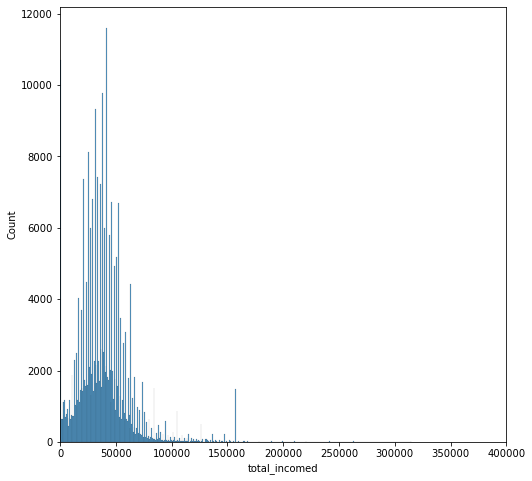

In [7]:
plot_distribution(msample_1980, "total_incomed")
msample_1980["total_incomed"].mean()

<AxesSubplot:xlabel='total_incomed'>

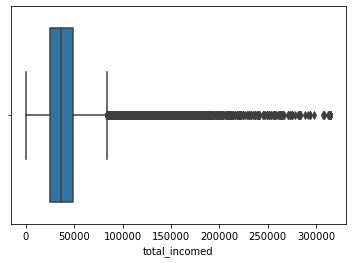

In [19]:
sns.boxplot(x=msample_1980['total_incomed'])

<AxesSubplot:>

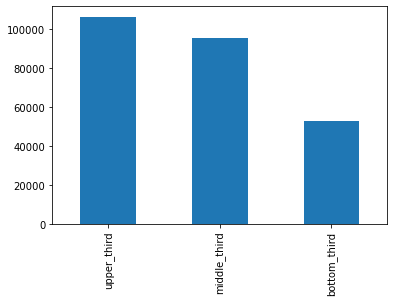

In [10]:
msample_1980['husband_distribution'].value_counts().plot(kind='bar')

#### **Table 2| Part 1: Descriptive Statistics, Women aged 21-35 with 2 or more children - 1980 PUMS**

Descriptive statistics and variable definitions for covariates, intruments and dependent variables are given in Table 2 from Angrist and Evans (1998) and replicated in the code below. 

Table 2 part 1 provides information on statistics and variable definition for covariates, instruments and dependent variables later used in the empirical analysis for the 1980 census data, while Table 2 part 2 provides the same information for 1990 census data. 

The covariate of main interest is *more than two children* and the first instrumental variable for this covariate is *same sex*, described as if the first two children were the same gender. The table also shows the two components of *same sex*, which are *two boys* and *two girls*. Just as stated in Angrist and Evans (1998), among all the women who already had a second child, 40.2 percent had a third, where the correspoding fraction for the 1990 sample is 37 percent. For both samples, around 50% of all the families with two childs have children of the same gender and above 51% of first births correspond to a boy.

Meanwhile, another instrument used in the empirical analysis correspond to multiple births, or *twins*. In the 1980 PUMS, multiple births is constructed as siblings who have the same age and quarter of birth (note: for the construction of this indicator, the age of the second and third child was used; this means, the twin birth corresponds to the mother's second birth). For the 1980 PUMS, the mean of *twins* is 0.09 for the sample of all women and 0.08 for the sample of married women. Since the variable quarter of birth is not reported for the 1990 PUMS dataset, the multiple birth variable was defined as children who have the same age.

Demographic variables include: mother's age, age at first birth, years of education, and indicators for race and ethnic background. 

The labor-supply variables are based on Census questions on *Worked for pay, weeks worked, hours/week, labor income (annual)*. The last two variables in the table measure Family income and a variable called non-wife income which measures the overall family income minus the wife's labor income. The descriptive statistics show that women's labor force participation, weeks and hours worked increased between 1980 and 1990.

In [16]:
#Table 2 for 1980
table1_1=table_sum_stats(data_all_women_1980)
table1_2=table_sum_stats(msample_1980)
table1_3=table_sum_stats_husbands(msample_1980)
data_frames = [table1_1, table1_2, table1_3]
Table2_1980 = reduce(lambda  left,right: pd.merge(left,right,on=['Variable'],
                                            how='left'), data_frames)

Table2_1980.rename(columns = {'Mean_x':'All women (mean)', 
                       'Std. Dev._x':'All women (std.dev)',
                       'Mean_y':'Married women (mean)',
                      'Std. Dev._y':'Married women (std.dev)',
                      'Mean':'Husbands (mean)',
                      'Std. Dev.':'Husbands (std.dev)'}, 
            inplace = True)

Table2_1980=Table2_1980[["Variable", "All women (mean)", "All women (std.dev)", "Married women (mean)", "Married women (std.dev)", 'Husbands (mean)', "Husbands (std.dev)"]]
Table2_1980 = Table2_1980.replace(np.nan, '-', regex=True)

print("The sample of all women for 1980 has", len(data_all_women_1980), "observations, while the sample for married couples has" , len(msample_1980), "observations")
Table2_1980

The sample of all women for 1980 has 394840 observations, while the sample for married couples has 254652 observations


,Variable,All women (mean),All women (std.dev),Married women (mean),Married women (std.dev),Husbands (mean),Husbands (std.dev)
0,Children ever born,2.552,0.808,2.508,0.769,-,-
1,More than two children,0.402,0.490,0.381,0.486,-,-
2,First child was a boy,0.511,0.500,0.514,0.500,-,-
3,Second child was a boy,0.511,0.500,0.512,0.500,-,-
4,First two children were boys,0.264,0.441,0.266,0.442,-,-
5,First two children were girls,0.242,0.428,0.239,0.427,-,-
6,First two children were the same sex,0.505,0.500,0.505,0.500,-,-
7,Second birth was a twin,0.009,0.092,0.008,0.091,-,-
8,Age,30.125,3.510,30.393,3.386,33.035,4.564
9,Age at first birth,20.515,2.938,21.216,2.904,24.352,3.989


**Table 2| Part 2: Descriptive Statistics, Women aged 21-35 with 2 or more children - 1990 PUMS**

In [29]:
#Table 2 for 1990
table1_1=table_sum_stats(data_all_women_1990)
table1_2=table_sum_stats(msample_1990)
table1_3=table_sum_stats_husbands(msample_1990)
data_frames = [table1_1, table1_2, table1_3]
Table2_1990 = reduce(lambda  left,right: pd.merge(left,right,on=['Variable'],
                                            how='left'), data_frames)

Table2_1990.rename(columns = {'Mean_x':'All women (mean)', 
                       'Std. Dev._x':'All women (std.dev)',
                       'Mean_y':'Married women (mean)',
                      'Std. Dev._y':'Married women (std.dev)',
                      'Mean':'Husbands (mean)',
                      'Std. Dev.':'Husbands (std.dev)'}, 
            inplace = True)

Table2_1990=Table2_1990[["Variable", "All women (mean)", "All women (std.dev)", "Married women (mean)", "Married women (std.dev)", 'Husbands (mean)', "Husbands (std.dev)"]]
Table2_1990 = Table2_1990.replace(np.nan, '-', regex=True)
print("The sample of all women for 1990 has", len(data_all_women_1990), "observations, while the sample for married couples has" , len(msample_1990), "observations")
Table2_1990

The sample of all women for 1990 has 380007 observations, while the sample for married couples has 301595 observations


,Variable,All women (mean),All women (std.dev),Married women (mean),Married women (std.dev),Husbands (mean),Husbands (std.dev)
0,Children ever born,2.495,0.767,2.477,0.747,-,-
1,More than two children,0.370,0.483,0.363,0.481,-,-
2,First child was a boy,0.513,0.500,0.514,0.500,-,-
3,Second child was a boy,0.511,0.500,0.512,0.500,-,-
4,First two children were boys,0.264,0.441,0.265,0.441,-,-
5,First two children were girls,0.240,0.427,0.238,0.426,-,-
6,First two children were the same sex,0.504,0.500,0.503,0.500,-,-
7,Second birth was a twin,0.018,0.131,0.016,0.127,-,-
8,Age,30.434,3.463,30.658,3.339,33.461,4.764
9,Age at first birth,21.809,3.487,22.278,3.459,25.08,4.695


#### Table 3: Fraction of Families that had another child by parity and sex of children

Table 3 reports estimates of the impact of child sex and the sex mix on fertility. I have divided the table into two panels for each census data's samples.

The first panel of Table 3 shows the sex preferences in families with *more than one children* and it shows the fraction of women with at least one kid who had a second one, conditional on the sex of the first child. The third row shows the difference by sex. It is shown, for 1980 and 1990 data, that there is almost non difference, with the biggest difference captured by the 1990 census data all women sample. However, even in this case, the impact of the sex of the first child in fertility is very low. 


In [36]:
Table3_1_1=Table_3_panel_1(data_all_women_1980_one)
Table3_1_2=Table_3_panel_1(msample_1980_one)
Table3_2_1=Table_3_panel_2(data_all_women_1980)
Table3_2_2=Table_3_panel_2(msample_1980)

keys = ['All women, PUMS 1980', 'Married women, PUMS 1980']
frames1 = [Table3_1_1, Table3_1_2]
frames2 = [Table3_2_1, Table3_2_2]
table3_1 = pd.concat(frames1, axis=1, keys=keys) 
table3_2 = pd.concat(frames2, axis=1, keys=keys)

Table3_1_3=Table_3_panel_1(data_all_women_1990_one)
Table3_1_4=Table_3_panel_1(msample_1990_one)
Table3_2_3=Table_3_panel_2(data_all_women_1990)
Table3_2_4=Table_3_panel_2(msample_1990)

keys = ['All women, PUMS 1990', 'Married women, PUMS 1990']
frames1 = [Table3_1_3, Table3_1_4]
frames2 = [Table3_2_3, Table3_2_4]
table3_3 = pd.concat(frames1, axis=1, keys=keys) 
table3_4 = pd.concat(frames2, axis=1, keys=keys)

In [42]:
table3_1

All women, PUMS 1980  \
                                                     Fraction of sample   
Sex of first child in families with one or more...                        
(1) one girl                                                   0.511534   
(2) one boy                                                    0.488466   
difference (2) - (1)                                                NaN   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with one or more...                                   
(1) one girl                                                              0.688577   
(2) one boy                                                               0.688733   
difference (2) - (1)                                                      0.000156   

                                                   Married women, PUMS 1980  \
                                                         Fraction of sample   
Sex of first child in families with one or more...                            
(1) one girl                                                       0.514948   
(2) one boy                                                        0.485052   
difference (2) - (1)                                                    NaN   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with one or more...                                  
(1) one girl                                                              0.713986  
(2) one boy                                                               0.713519  
difference (2) - (1)                                                     -0.000467

In [43]:
table3_3

All women, PUMS 1990  \
                                                     Fraction of sample   
Sex of first child in families with one or more...                        
(1) one girl                                                   0.511506   
(2) one boy                                                    0.488494   
difference (2) - (1)                                                NaN   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with one or more...                                   
(1) one girl                                                              0.666246   
(2) one boy                                                               0.669218   
difference (2) - (1)                                                      0.002972   

                                                   Married women, PUMS 1990  \
                                                         Fraction of sample   
Sex of first child in families with one or more...                            
(1) one girl                                                       0.513675   
(2) one boy                                                        0.486325   
difference (2) - (1)                                                    NaN   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with one or more...                                  
(1) one girl                                                              0.700094  
(2) one boy                                                               0.702045  
difference (2) - (1)                                                      0.001952

The second panel of table 3 shows the relationship between the fraction of women who have a third child and the sex of hers first two children. The first three rows document the fraction of women who had 1) one girl and one boy as the two first children, 2) whether the two kids were two boys, and 3) whether the first two kids were two girls. The last two rows show the fraction who had a same sex composition in the first birth and the difference between the same-sex and the mixed-sex group averages. 

The results for both datasets (1980 and 1990 PUMS) show that women with two children of the same sex are much more likely to have a 3rd child in comparison with women who had one girl and one boy as the first couple of children. For example, in the 1990 all women sample, 40,17% of women who had a same-sex child composition as first two kids had another child afterwards. In comparison, 33,86% of women who had a mixed-sex composition had a third child. On the other hand, the data suggest that the relationship between sex composition and probability of having a third child is slighly higher for married couples, where the difference between same and mixed-sex composition is approximatly 7%. 

In [44]:
table3_2

All women, PUMS 1980  \
                                                     Fraction of sample   
Sex of first child in families with two or more...                        
(1) one girl one boy                                            0.49461   
(2) two boys                                                   0.263719   
(3) two girls                                                   0.24167   
(4) both same sex                                               0.50539   
Difference (4) - (1)                                                  -   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with two or more...                                   
(1) one girl one boy                                                      0.371971   
(2) two boys                                                              0.422686   
(3) two girls                                                             0.441150   
(4) both same sex                                                         0.431515   
Difference (4) - (1)                                                      0.059544   

                                                   Married women, PUMS 1980  \
                                                         Fraction of sample   
Sex of first child in families with two or more...                            
(1) one girl one boy                                               0.494652   
(2) two boys                                                       0.266073   
(3) two girls                                                      0.239276   
(4) both same sex                                                  0.505348   
Difference (4) - (1)                                                      -   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with two or more...                                  
(1) one girl one boy                                                      0.346742  
(2) two boys                                                              0.403831  
(3) two girls                                                             0.424637  
(4) both same sex                                                         0.413683  
Difference (4) - (1)                                                      0.066941

In [45]:
table3_4

All women, PUMS 1990  \
                                                     Fraction of sample   
Sex of first child in families with two or more...                        
(1) one girl one boy                                           0.495738   
(2) two boys                                                    0.26389   
(3) two girls                                                  0.240372   
(4) both same sex                                              0.504262   
Difference (4) - (1)                                                  -   

                                                                                    \
                                                   Fraction that had another child   
Sex of first child in families with two or more...                                   
(1) one girl one boy                                                      0.338696   
(2) two boys                                                              0.396869   
(3) two girls                                                             0.407114   
(4) both same sex                                                         0.401752   
Difference (4) - (1)                                                      0.063056   

                                                   Married women, PUMS 1990  \
                                                         Fraction of sample   
Sex of first child in families with two or more...                            
(1) one girl one boy                                               0.497173   
(2) two boys                                                       0.264713   
(3) two girls                                                      0.238114   
(4) both same sex                                                  0.502827   
Difference (4) - (1)                                                      -   

                                                                                    
                                                   Fraction that had another child  
Sex of first child in families with two or more...                                  
(1) one girl one boy                                                      0.327660  
(2) two boys                                                              0.391816  
(3) two girls                                                             0.403529  
(4) both same sex                                                         0.397362  
Difference (4) - (1)                                                      0.069702

## II. Fertility and Labor Supply 

### A. Wald Estimates 

The authors argue that the sex composition of siblings (i.e., same sex) is *randomly assigned*. That means that reduced-form regressions of fertility and labor supply outcomes on the instruments have a causal interpretation. In this section, the authors show how statistical techniques can be used to ilustrate how the sex-mix strategy identifies the effect of fertility on both mom and dad's labor supply.

They consider the following equation:

\begin{equation}
y_{i} = \alpha + \beta x_{i} + \varepsilon_{i},
\end{equation}

where $y_{i}$ is a measure of labor supply and $x_{i}$ is the endogenous fertility measure. In the case of Angrist and Evans (1998), they measure labor supply through the following variables: worked per pay, weeks worked, hours worked, total income, and family income. For married couples, this also might include non-wife income. The endogenous variable for fertility measure is more than 2 kids. 

Let's denote $z_{i}$ as the binary instrument *same sex*. Then, the IV estimate of $\beta$ is:

\begin{equation}
\beta_{IV} =  \frac{(\bar{y_{1}} - \bar{y_{0}})}{(\bar{x_{1}} - \bar{x_{0}})}
\end{equation}

where $\bar{y_{1}}$ is the mean of $y_{i}$ for those observations with $z_{i}=1$ and other terms are similarly defined. The IV estimator attributes any effect of $z_{i}$ on $y_{i}$ to the effect of $z_{i}$ on $x_{i}$ (see causal graph). One important feature of the model stated on the paper is that following Guido W. Imbens and Angrist (1994), the $\beta_{IV}$ can be interpreted as a Local Average Treatment Effect (LATE) specific to the instrument $z_{i}$. In this case then, the estimator measures the average effect of $x_{i}$ on $y_{i}$ for individuals whose fertility has been affected by their children's sex mix measured by same sex.

Table 5 reports Wald Estimates of Labor-Supply Models for the 1980 PUMS and 1990 PUMS all women samples when same sex is used as an instrument. For the calculation of the Wald Estimates when twins is used as instrument, the authors only use the 1980 PUMS dataset. For computational reasons, I have splitted Table 5 into two parts: the first part shows the difference in means by instrument and the second part calculates the wald estimate using as covariates more 2 kids and number of children. The results replicated here are extremly close to the ones reported in Angrist and Evans (1998).

**Table 5 | Part 1: Difference in meands by Instrument**

The first two rows of Table 5 Part 1 concentrates on estimating the denominator of the Wald Estimate.The results show that the effect of same sex instrument on more than 2 children is 0.0059 for in 1980 and 0.063 in 1990. The effect of same sex on number of children is 0.075 in 1980 and 0.084 in 1990. For the census data of 1980, the effect of the twin instrument on the probability of having a third child is 0.60 and the effects of twins on number of children is 0.81. 

After the first two rows, the authors calculate the nominator of the Wald estimate for alternative labor supply outcomes using same sex as instrument. These results show that women with two children of the same sex have a lower probability of working (-0.079), work less hours per year (-0.30) and work fewer weeks per year (-0.37). Also, they have lower annual earnings and lower family income.

In [35]:
outcomes_means=["more2k", "KIDCOUNT", "workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_means_1980=mean_differences_instruments(data_all_women_1980, outcomes_means)
Table5_means_1990=mean_differences_instruments_90(data_all_women_1990, outcomes_means)
Table5_part1=pd.concat([Table5_means_1980, Table5_means_1990], axis=1, keys=["1980 PUMS", "1990 PUMS"])
Table5_part1

1980 PUMS                                     \
              Mean difference by Same Sex Std. err. Mean difference by twins   
outcomes                                                                       
more2k                             0.0595    0.0016                   0.6031   
KIDCOUNT                           0.0754    0.0026                   0.8114   
workedm                           -0.0079    0.0016                  -0.0458   
WEEKSM                            -0.3787    0.0709                  -1.9760   
HOURSM                            -0.3089    0.0602                  -1.9523   
total_incomem                   -130.3005   34.3881                -560.3765   
faminc_log                        -0.0015    0.0043                  -0.0374   

                                          1990 PUMS            
               Std.err. Mean difference by Same Sex Std. err.  
outcomes                                                       
more2k           0.0008                      0.0631    0.0016  
KIDCOUNT         0.0118                      0.0837    0.0025  
workedm          0.0086                     -0.0055    0.0015  
WEEKSM           0.3790                     -0.3119    0.0742  
HOURSM           0.3196                     -0.2369    0.0619  
total_incomem  186.3776                   -105.2232   41.9951  
faminc_log       0.0248                     -0.0080    0.0046

**Table 5 | Part 2: Wald Estimates with covariates**

The second part of Table 5 reports the Wald estimates when $x_{i}$ is either more than 2 children or number of children. For the case of more than 2 children in the 1980 PUMS, the results show that having a third kid will reduce labor supply in -13.2 percentage points, weeks worked in about 6.4 weeks and hours of work per week in 5.18. The loss in income is -2188 US Dollars (very close to -2200 reported in Angrist and Evans). The replicated results also support the findings in the original paper that results for 1990 PUMS are also negative but somehow smaller, with the exception of the effect on family income, which is larger than 1980. 

The results for when number of children is used puts these effects in *per-child terms* and are a bit smaller for each year. The coefficients for when twins are used as instrument are relatively smaller than same sex instrument and later on the authors do a comparison of the difference of this instruments. Furthermore, the authors argue that the difference in outcomes for more than 2 kids and number of children is a proportional factor of 0.75. Thus, they chose to estimate coefficients for the effect of more than 2 children as endogenous regressor since it captures the effect induced by either instrument: same-sex composition of the first two kids and second-birth twins.

In [36]:
outcomes_wald_1980=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_1=wald_estimates_regressions(data_all_women_1980, outcomes_wald_1980, "same_sex")
Table5_2=wald_estimates_regressions(data_all_women_1980, outcomes_wald_1980, "twins")
outcomes_wald_1990=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log"]
Table5_3=wald_estimates_regressions(data_all_women_1990, outcomes_wald_1990, "same_sex")
Table5_part2=pd.concat([Table5_1, Table5_2, Table5_3], axis=1, keys=["Wald Estimates-Same sex 1980 PUMS", "Wald Estimates-Twins 1980 PUMS", "Wald Estimates-Same sex 1990 PUMS"])
Table5_part2

Wald Estimates-Same sex 1980 PUMS                               \
                           More than 2 children Std. err. Number of children   
outcomes                                                                       
workedm                                  -0.132     0.026             -0.104   
WEEKSM                                   -6.360     1.191             -5.022   
HOURSM                                   -5.187     1.011             -4.096   
total_incomem                         -2188.305   577.549          -1728.163   
faminc_log                               -0.024     0.072             -0.019   

                       Wald Estimates-Twins 1980 PUMS            \
              Std.err.           More than 2 children Std. err.   
outcomes                                                          
workedm          0.021                         -0.076     0.014   
WEEKSM           0.941                         -3.276     0.638   
HOURSM           0.799                         -3.237     0.542   
total_incomem  456.106                       -929.162   309.461   
faminc_log       0.057                         -0.062     0.039   

                                          Wald Estimates-Same sex 1990 PUMS  \
              Number of children Std.err.              More than 2 children   
outcomes                                                                      
workedm                   -0.056    0.011                            -0.087   
WEEKSM                    -2.435    0.474                            -4.947   
HOURSM                    -2.406    0.403                            -3.757   
total_incomem           -690.642  230.021                         -1668.729   
faminc_log                -0.046    0.029                            -0.127   

                                                     
              Std. err. Number of children Std.err.  
outcomes                                             
workedm           0.024             -0.065    0.018  
WEEKSM            1.177             -3.728    0.887  
HOURSM            0.982             -2.831    0.740  
total_incomem   666.013          -1257.525  501.896  
faminc_log        0.074             -0.096    0.055

### B. Two-stage Least - Squares Estimation

In this section, the authors discuss and compare two-stage least-squares (2SLS) and ordinary least-squares (OLS). In particular, the authors are interested in the following equation:

**Equation 4**
\begin{equation}
    y_i = \alpha_{0}\prime w_i + \alpha_1 s_{1i} +  \alpha_2 s_{2i}  + \beta x_i + \varepsilon_i 
\end{equation}

where $w_i$ is a vector of demographic variables-includes exogenous cofounders such as mother's age, age at first birth and race indicator-, $s_{1}$ and $s_{2}$ are indicators for whether the first child is a boy or second child is a boy and $x_i$ stands for the endogenous regressor. 

The first-stage equation relating more than 2 children to same sex is:

**Equation 5**
\begin{equation}
    x_i = \phi_{0}\prime w_i + \phi_1 s_{1i} +  \alpha_2 s_{2i}  + \lambda \ same \ sex_i + \eta_i 
\end{equation}

where $\lambda$ is the first-stage effect of the instrument. Because of same sex is actually made out of two components- two boys and two girls- there is another identification strategy that can be implemented by using these two components as instruments. In this case, the equation of interest has to drop either $s_1i$ or $s_2i$ because of multicolinearity:

**Equation 6**
\begin{equation}
    y_i = \alpha_{0}\prime w_i + \alpha_1 s_{1i}  + \beta x_i + \varepsilon_i 
\end{equation}

The first-stage relationship between $x_i$ and sex mix is then:

**Equation 7**
\begin{equation}
    x_i = \phi_{0}\prime \ w_i + \phi_1 \ s_{1i} +  \lambda_0 \ two \ boys_i + \lambda_1 \ two \ girls_i + \eta_i 
\end{equation}

### C. 2SLS Results

Table 6 of Angrist and Evans (1998) reports the first stage relationship between sex mix measured by same sex and two-boys/two-girls and fertility measured by more than 2 kids for all women and married women samples in 1980 and 1990 PUMS. Because of the size of the tables, I also splitted Table 6 into two parts: First part shows the results for 1980 samples and the second part does the same for 1990 samples. 

For each part: column (1) shows the estimates of the simple regression of same sex on more than 2 kids; column (2) estimates equation 5; column (3) estimates equation 7; columns (4), (5) and (6) do the same for married women samples. The coefficients of interest are:

boy1st
boy2nd
same_sex
two_boys
two_girls


The results replicated in this notebook are very similar to the original ones presented in Angrist and Evans (1998).

**Table 6 Part 1: OLS Estimates of *More than 2 children* equations for 1980 PUMS**

Table 6 part 1 show the first-stage results for 1980 all women and married women samples. The coefficients reveal that for the sample of all women, women who have a same-sex kids composition are 6.12 percentage points more likely to have a third child in a model with covariates, where the correspondent estimate for the married women sample is 6.89 percentage points. The probability of having a third child when having two boys as first two childs is 5.25%, whereas two girls 6.99%. These coefficients are a bit larger for married women.

In [41]:
OLS_Regressions_more2k(data_all_women_1980, msample_1980)

**Table 6 Part 2: OLS Estimates of *More than 2 children* equations for 1990 PUMS**

In [40]:
OLS_Regressions_more2k(data_all_women_1990, msample_1990)

**Table 7: OLS and 2SLS Estimates of Labor-Supply model 1980 Census Data**

Table 7 reports estimates of OLS estimates and 2SLS estimates (this one using same sex and two boys/two girls) as instruments. I followed the specifications of the authors, where the exogenous regressors of the model are the same as in Table 6, but the coefficients are not reported inside the table. Also, in models with more than 1 instrument, the variable boy2nd is dropped to avoid multicollinearity problems. The models are estimated for all women, married women and husbands of married women. The table show only the coefficient for more than 2 children of each estimated model. 

**OLS Estimates**

Following what the authors find in the original paper, OLS estimates for all women and married women suggest that having a third child reduces the probability of being at the labor market (measured by worked for pay). This estimate is -0.177 for the sample of all women and -0.167 for married women, which means that the presence of a third child reduces the probability of working by around 17% points. About weeks worked, the estimates for all women are also negative (-8.99) and somehow greater than for married women (-8.04). Family income falls about 13% and the effecton total income for women is -3,768 for the sample of all women, whereas for the married sample this is -3,148. 

In contrast with the findings for women, the effect of more than 2 children on labor supply outcomes are small for husbands. For example, OLS estimates for the effect of a third child on worked for pay is -0.008 and estimates for weeks worked are -0.901. An interesting finding is that the coefficient for hours worked per week is positive for men and the coefficient on labor income is smaller relative to women.

**IV Estimates**

The replicated IV estimates using same sex as instrument for the sample of all women are very close to the original findinds. The coefficient on worked for pay is -0.117, weeks worked -5.5, hours worked -4.5, total income -1,900. The estimates for IV are smaller than the estimates from OLS regressions, which suggests that OLS tends to exaggerate the effect of more kids on labor supply outcomes. On the other hand, IV estimates on workedd (worked for pay) for husbands reflect almost no effect of an increase in number of kids on these outcomes, in contrast to the small but significate finding in the OLS estimate.

---
<span style="color:coral">**Note**:</span> Husband's coefficients differ from the original findings in Angrist and Evans (1998). This could be due to the issue discussed above, were the income distribution for dads/husbands present certain outliers that the authors might have solved bu dropping those observations.

---

For each model, the outcomes and controls will be different because the authors want to measure labor supply outcomes for moms and dads. Also, for the IV models, the variable boy2nd is dropped from the covariate vector to avoid multicollinealty. In the following code, I define the different dependent variables and controls, and then apply a function that replicates table 7.

In [20]:
outcomes_labor_supply_moms=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
outcomes_labor_supply_dads=["workedd", "WEEKSD", "HOURSD", "total_incomed", "faminc_log", "nonmomi_log"]
controls_OLS_moms = ["const", "more2k", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_1_moms=["const", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_2_moms=["const", 'AGEM', 'agefstm', "boy1st", "blackm", "hispm", "otheracem"]
controls_OLS_dads = ["const", "more2k", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispd", "otheraced"]
controls_IV_1_dads=["const", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispm", "otheraced"]
controls_IV_2_dads=["const", 'AGED', 'agefstd', "boy1st", "blackd", "hispd", "otheraced"]

In [21]:
Table7_1=OLS_Labor_Supply_Models(data_all_women_1980, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table7_2=OLS_Labor_Supply_Models(msample_1980, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table7_3=OLS_Labor_Supply_Models(msample_1980, outcomes_labor_supply_dads, controls_OLS_dads, controls_IV_1_dads, controls_IV_2_dads)

keys=["All women", "Married Women", "Husbands"]
frames=[Table7_1, Table7_2, Table7_3]
Table7=pd.concat(frames, axis=1, keys=keys)
Table7 = Table7.replace(np.nan, '-', regex=True)
Table7

All women                                          \
                OLS (1) Std.err (1) IV-same sex (2) Std.err (2)   
workedm          -0.177       0.002          -0.117       0.025   
WEEKSM           -8.998       0.072          -5.548       1.117   
HOURSM           -6.667       0.062          -4.536       0.953   
total_incomem   -3768.2      35.391        -1900.04      546.19   
faminc_log       -0.137       0.004          -0.026       0.068   
nonmomi_log       0.208       0.008           0.113       0.121   
workedd               -           -               -           -   
WEEKSD                -           -               -           -   
HOURSD                -           -               -           -   
total_incomed         -           -               -           -   

                                                     Married Women  \
              IV-two girls, two boys (3) Std.err (3)       OLS (1)   
workedm                            -0.11       0.025        -0.167   
WEEKSM                            -5.252        1.11        -8.044   
HOURSM                            -4.298       0.946         -5.99   
total_incomem                   -1810.25     542.853       -3148.3   
faminc_log                        -0.034       0.068         -0.14   
nonmomi_log                        0.075       0.121        -0.062   
workedd                                -           -             -   
WEEKSD                                 -           -             -   
HOURSD                                 -           -             -   
total_incomed                          -           -             -   

                                                       \
              Std.err (1) IV-same sex (2) Std.err (2)   
workedm             0.002          -0.117       0.028   
WEEKSM              0.089          -5.252       1.217   
HOURSM              0.075          -4.763       1.022   
total_incomem      42.068        -1270.72     573.312   
faminc_log          0.004          -0.045       0.059   
nonmomi_log         0.005           0.033       0.071   
workedd                 -               -           -   
WEEKSD                  -               -           -   
HOURSD                  -               -           -   
total_incomed           -               -           -   

                                                     Husbands              \
              IV-two girls, two boys (3) Std.err (3)  OLS (1) Std.err (1)   
workedm                           -0.109       0.028        -           -   
WEEKSM                            -5.014       1.208        -           -   
HOURSM                            -4.531       1.014        -           -   
total_incomem                   -1254.12     569.842        -           -   
faminc_log                        -0.049       0.059    -0.16       0.004   
nonmomi_log                        0.022        0.07   -0.084       0.005   
workedd                                -           -   -0.008       0.001   
WEEKSD                                 -           -   -0.901       0.044   
HOURSD                                 -           -    0.152       0.052   
total_incomed                          -           - -1763.01     103.695   

                                                                      \
              IV-same sex (2) Std.err (2) IV-two girls, two boys (3)   
workedm                     -           -                          -   
WEEKSM                      -           -                          -   
HOURSM                      -           -                          -   
total_incomem               -           -                          -   
faminc_log             -0.045        0.06                     -0.051   
nonmomi_log             0.032       0.071                      0.019   
workedd                 0.004       0.009                      0.001   
WEEKSD                  0.593       0.601                      0.408   
HOURSD                  0.525       0.

In [32]:
model_iv = IV2SLS.from_formula('total_incomem ~ 1 + AGEM + agefstm + boy1st + hispm + blackm + otheracem + [more2k ~ two_boys + two_girls]',data_all_women_1980)
iv1 = model_iv.fit() # try HCV-robust
print(iv1.summary)
# sargan test of overidentifying restrictions
print(iv1.sargan)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          total_incomem   R-squared:                      0.0565
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0565
No. Observations:              394840   F-statistic:                 1.517e+04
Date:                Sun, Jul 18 2021   P-value (F-stat)                0.0000
Time:                        23:15:59   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -3006.3     273.61    -10.988     0.0000     -3542.6     -2470.1
AGEM           584.92     17.180     34.047     0.00

**Table 8: OLS and 2SLS Estimates of Labor Supply Models using 1990 Census Data**

The results for 1990 Census Data are quite similar to the ones found in 1980 Census Data. The authors find a significant difference, however, and this is a higher impact on married women's earnings for the year 1990 that could be due to an increase in women's earnings. The authors suggest that the reason women present higher wages is because of the age at which they are having children; Table 2 shows that the mean of age of first birth increased between 1980 and 1990 from aproximatly 21 to 22, thus having additional work experience might result in higher wages.

---
<span style="color:coral">**Note**:</span> Wife's coefficients differ from the original findings in Angrist and Evans (1998) for the year 1990, as well as husband's earnings. This could be explain by the fact that the authors transform these variables by deflacting them for US 1995 dollars. For year 1980, the replication code stated the deflactor rate; however, this is not provided for the 1990 dataset.

---

In [33]:
Table8_1=OLS_Labor_Supply_Models(data_all_women_1990, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table8_2=OLS_Labor_Supply_Models(msample_1990, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)
Table8_3=OLS_Labor_Supply_Models(msample_1990, outcomes_labor_supply_dads, controls_OLS_dads, controls_IV_1_dads, controls_IV_2_dads)

keys=["All women", "Married Women", "Husbands"]
frames=[Table8_1, Table8_2, Table8_3]
Table8=pd.concat(frames, axis=1, keys=keys)
Table8 = Table8.replace(np.nan, '-', regex=True)
Table8

All women                                          \
                OLS (1) Std.err (1) IV-same sex (2) Std.err (2)   
workedm          -0.154       0.002          -0.095       0.024   
WEEKSM           -8.725       0.077          -5.475       1.156   
HOURSM           -6.739       0.065           -4.12       0.973   
total_incomem  -3934.57      43.968        -1817.19     656.605   
faminc_log       -0.131       0.005          -0.107        0.07   
nonmomi_log       0.244       0.009          -0.075       0.131   
workedd               -           -               -           -   
WEEKSD                -           -               -           -   
HOURSD                -           -               -           -   
total_incomed         -           -               -           -   

                                                     Married Women  \
              IV-two girls, two boys (3) Std.err (3)       OLS (1)   
workedm                           -0.095       0.024        -0.147   
WEEKSM                            -5.458       1.156        -8.255   
HOURSM                            -4.131       0.973        -6.336   
total_incomem                   -1818.02     656.504      -3705.16   
faminc_log                        -0.107        0.07        -0.109   
nonmomi_log                       -0.074       0.131        -0.012   
workedd                                -           -             -   
WEEKSD                                 -           -             -   
HOURSD                                 -           -             -   
total_incomed                          -           -             -   

                                                       \
              Std.err (1) IV-same sex (2) Std.err (2)   
workedm             0.002            -0.1       0.024   
WEEKSM              0.087          -5.227       1.162   
HOURSM              0.073          -3.871       0.964   
total_incomem      50.239        -1988.76      667.81   
faminc_log          0.004          -0.028       0.052   
nonmomi_log         0.005            0.04       0.068   
workedd                 -               -           -   
WEEKSD                  -               -           -   
HOURSD                  -               -           -   
total_incomed           -               -           -   

                                                     Husbands              \
              IV-two girls, two boys (3) Std.err (3)  OLS (1) Std.err (1)   
workedm                             -0.1       0.024        -           -   
WEEKSM                            -5.223       1.162        -           -   
HOURSM                            -3.873       0.964        -           -   
total_incomem                   -1989.19     667.781        -           -   
faminc_log                        -0.028       0.052   -0.129       0.004   
nonmomi_log                         0.04       0.068   -0.031       0.005   
workedd                                -           -   -0.011       0.001   
WEEKSD                                 -           -   -1.038       0.046   
HOURSD                                 -           -    0.037       0.052   
total_incomed                          -           -  429.192      115.18   

                                                                      \
              IV-same sex (2) Std.err (2) IV-two girls, two boys (3)   
workedm                     -           -                          -   
WEEKSM                      -           -                          -   
HOURSM                      -           -                          -   
total_incomem               -           -                          -   
faminc_log             -0.024       0.053                     -0.023   
nonmomi_log             0.045       0.068                      0.045   
workedd                 0.009       0.009                       0.01   
WEEKSD                  0.787       0.618                      0.803   
HOURSD                  0.458       0.

### D. Other Specification Issues


In [82]:
msample_1980=pd.get_dummies(msample_1980, columns=["STATE"])

In [79]:
def IV_more_controls(data, outcomes):

    table = pd.DataFrame(
        {
            "IV-same sex (1)": [],
            "Std.err (2)": [],
        }
    )
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:
        data=data
        formula = outcome + " ~ 1 + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex] + educm + np.power(educm, 2) + np.power(AGEM, 2) + agefstd + AGED + np.power(AGED, 2) + total_incomed + STATE_1 + STATE_2 + STATE_4 + STATE_5 + STATE_6 + STATE_8 + STATE_9 + STATE_10 + STATE_11 + STATE_12 + STATE_13 + STATE_15 + STATE_16 + STATE_17 + STATE_18 + STATE_19 + STATE_20 + STATE_21 + STATE_22 + STATE_23 + STATE_24 + STATE_25 + STATE_26 + STATE_27 + STATE_28 + STATE_29 + STATE_30 + STATE_31 + STATE_32 + STATE_33 + STATE_34 + STATE_35 + STATE_36 + STATE_37 + STATE_38 + STATE_39 + STATE_40 + STATE_41 + STATE_42 + STATE_44 + STATE_45 + STATE_46 + STATE_47 + STATE_48 + STATE_49 + STATE_50 + STATE_51 + STATE_53 + STATE_54 + STATE_55"
        mod = IV2SLS.from_formula(formula, data)
        iv_res = mod.fit(cov_type='robust')       
        
        outputs = [
                iv_res.params["more2k"],
                iv_res.std_errors["more2k"],            
        ]
        
        table.loc[outcome] = outputs
        table = table.round(4)

    return table

In [81]:
table=IV_more_controls(msample_1980, ["workedm", "WEEKSM", "HOURSM", "total_incomem"])
table

,IV-same sex (1),Std.err (2)
outcomes,,
workedm,-0.1205,0.0273
WEEKSM,-5.4851,1.1872
HOURSM,-5.0484,0.9946
total_incomem,-1309.6709,561.2751


In [86]:
data=data_1980
data_all_women_80_exp=data[((data['AGEM']>=21) & (data['AGEM']<=45)) & (data['KIDCOUNT']>=2) & (data['AGEQ2ND']>4) & (data['agefstm']>=15) 
            & (data['ASEX']==0) & (data['AAGE']==0) & (data['AQTRBRTH']==0)  
            & (data['ASEX2ND']==0) & (data['AAGE2ND']==0) & (data['AQTRBRTH']==0)].copy()

data_all_women_80_exp.index = range(len(data_all_women_80_exp.index))
len(data_all_women_80_exp)

552621

In [91]:
formula = " workedm ~ 1 + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex]"
mod = IV2SLS.from_formula(formula, data_all_women_80_exp)
iv_res = mod.fit(cov_type='robust')
iv_res.params["more2k"]

-0.09539257520248157

In [90]:
iv_res.std_errors["more2k"]

0.021012542245300827

Table 9

In [ ]:
Interaction1="more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad",    
outcome="workedm"
Table9_1=OLS_Labor_Supply_Interactions_wifes(msample_1980, Interaction1, "workedm")

Interaction2="more2k_lessgrad_earnings", "more2k_hsgrad_earnings", "more2k_moregrad_earnings" 
outcome="workedm"
Table9_1_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third, Interaction2, "workedm")

Interaction3="more2k_lessgrad_husbands", "more2k_hsgrad_husbands", "more2k_moregrad_husbands" 
outcome="workedd"
Table9_1_3=OLS_Labor_Supply_Interactions_husbands(sample01, sample02, sample03, Interaction3, "workedd")

frames=[Table9_1, Table9_1_2, Table9_1_3]
Table9_OLS_worked=pd.concat(frames, axis=0)

In [ ]:
Interaction4="samesex_bottomthird", "samesex_middlethird", "samesex_upperthird", "samesex_lessgrad", "samesex_hsgrad", "samesex_moregrad",       
outcome="more2k"
Table9_1_4=OLS_Labor_Supply_First_Stage_wifes(msample_1980, Interaction4, "more2k")

Interaction5="samesex_lessgrad_earnings", "samesex_hsgrad_earnings", "samesex_moregrad_earnings",       
outcome="more2k"
Table9_1_5=OLS_Labor_Supply_First_Stage_wifes(sample_middle_third, Interaction5, "more2k")

Interaction6="samesex_lessgrad", "samesex_hsgrad", "samesex_moregrad",       
outcome="more2k"
Table9_1_6=OLS_Labor_Supply_First_Stage_husbands(msample_1980, Interaction6, "more2k")

Table9_OLS_fs=pd.concat([Table9_1_4, Table9_1_5, Table9_1_6], axis=0)
Table9_OLS_fs.index=Table9_OLS_worked.index

In [ ]:
Table9_IV_worked=IV_Labor_Supply_Interactions(msample_1980, sample_middle_third, sample01, sample02, sample03, "workedm", "workedd")

In [31]:
msample_1980["lessgrad"].mean()

0.1782668111776071

In [32]:
msample_1980["moregrad"].mean()

0.33403232646906367

In [33]:
msample_1980["hsgrad"].mean()

0.48770086235332927

**Table 9| Part 1 : OLS and 2SLS Estimates for Labor Supply Models with Interaction Terms Using 1980 Census Data with *Worked for pay* as dependent variable**

In [ ]:
Variables1=["bottom_third", "middle_third", "upper_third", "lessgrad", "hsgrad", "moregrad"]
mean_1=mean_samples(msample_1980, Variables1, "workedm")

In [ ]:
Variables2=["lessgrad", "hsgrad", "moregrad"]
mean_2=mean_samples(sample_middle_third, Variables2, "workedm")

In [ ]:
Variables3=["lessgrad", "hsgrad", "moregrad"]
mean_3=mean_samples(msample_1980, Variables3, "workedd")

In [ ]:
frames=[mean_1, mean_2, mean_3]
Table9_means_1=pd.concat(frames, axis=0)
Table9_means_1.index=Table9_OLS_worked.index

In [ ]:
Table9_part1 = pd.concat([Table9_OLS_fs, Table9_means_1, Table9_OLS_worked, Table9_IV_worked], axis=1, keys=["First-Stage (more than 2 kids)", "", "OLS", "2SLS"])
Table9_part1

The table reports estimates of the coefficient on *worked for pay* for both married women and husband samples (1980) in equation (4), which was modified to allow interactions with wife's schooling and husband education. Main effects for each interaction in each sample are included in the equation. Other covariates in the model are those listed in the vector $w_i$

**Table 9| Part 2 : OLS and 2SLS Estimates for Labor Supply Models with Interaction Terms Using 1980 Census Data with *weeks worked per year* as dependent variable**

In [ ]:
Interaction1="more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad",   
outcome="WEEKSM"
Table9_2=OLS_Labor_Supply_Interactions_wifes(msample_1980, Interaction1, outcome)


Interaction2="more2k_lessgrad_earnings", "more2k_hsgrad_earnings", "more2k_moregrad_earnings" 
outcome="WEEKSM"
Table9_2_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third, Interaction2, outcome)


Interaction3="more2k_lessgrad_husbands", "more2k_hsgrad_husbands", "more2k_moregrad_husbands" 
outcome="WEEKSD"
Table9_2_3=OLS_Labor_Supply_Interactions_husbands(sample01, sample02, sample03, Interaction3, outcome)

frames=[Table9_2, Table9_2_2, Table9_2_3]
Table9_OLS_worked_2=pd.concat(frames, axis=0) 

Table9_IV_worked_2=IV_Labor_Supply_Interactions(msample_1980, sample_middle_third, sample01, sample02, sample03, "WEEKSM", "WEEKSD")

mean_4=mean_samples(msample_1980, Variables1, "WEEKSM")
mean_5=mean_samples(sample_middle_third, Variables2, "WEEKSM")
mean_6=mean_samples(msample_1980, Variables3, "WEEKSD")

frames=[mean_4, mean_5, mean_6]
Table9_means_2=pd.concat(frames, axis=0)
Table9_means_2.index=Table9_OLS_worked_2.index

In [ ]:
Table9_part2 = pd.concat([Table9_means_2, Table9_OLS_worked_2, Table9_IV_worked_2], axis=1, keys=["", "OLS", "2SLS"]).round(3)
Table9_part2

The table reports estimates of the coefficient on *weeks worked per year* for both married women and husband samples (1980 Census Data) in equation (4), which was modified to allow interactions with wife's schooling and husband education. Main effects for each interaction in each sample are included in the equation. Other covariates in the model are those listed in the vector $w_i$

Table 10 | Part 1

In [ ]:
Table10_1=OLS_Labor_Supply_Interactions_wifes(msample_1990, Interaction1, "workedm")
Table10_1_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third_1990, Interaction2, "workedm")
Table10_1_3=OLS_Labor_Supply_Interactions_husbands(sample04, sample05, sample06, Interaction3, "workedd")

frames=[Table10_1, Table10_1_2, Table10_1_3]
Table10_OLS_worked=pd.concat(frames, axis=0)

In [ ]:
Table10_1_4=OLS_Labor_Supply_First_Stage_wifes(msample_1990, Interaction4, "more2k")
Table10_1_5=OLS_Labor_Supply_First_Stage_wifes(sample_middle_third_1990, Interaction5, "more2k")
Table10_1_6=OLS_Labor_Supply_First_Stage_husbands(msample_1990, Interaction6, "more2k")
Table10_OLS_fs=pd.concat([Table10_1_4, Table10_1_5, Table10_1_6], axis=0)
Table10_OLS_fs.index=Table10_OLS_worked.index

In [ ]:
Table10_IV_worked=IV_Labor_Supply_Interactions(msample_1990, sample_middle_third_1990, sample04, sample05, sample06, "workedm", "workedd")

In [ ]:
mean_7=mean_samples(msample_1990, Variables1, "workedm")
mean_8=mean_samples(sample_middle_third_1990, Variables2, "workedm")
mean_9=mean_samples(msample_1990, Variables3, "workedd")
frames=[mean_7, mean_8, mean_9]
Table10_means_1=pd.concat(frames, axis=0)
Table10_means_1.index=Table10_OLS_worked.index
Table10_part1 = pd.concat([Table10_OLS_fs, Table10_means_1, Table10_OLS_worked, Table10_IV_worked], axis=1, keys=["First-Stage (more than 2 kids)", "", "OLS", "2SLS"])
Table10_part1

**Table 10 | Part 2**

In [ ]:
Table10_2=OLS_Labor_Supply_Interactions_wifes(msample_1990, Interaction1, "WEEKSM")
Table10_2_2=OLS_Labor_Supply_Interactions_wifes(sample_middle_third_1990, Interaction2, "WEEKSM")
Table10_2_3=OLS_Labor_Supply_Interactions_husbands(sample04, sample05, sample06, Interaction3, "WEEKSD")

frames=[Table10_2, Table10_2_2, Table10_2_3]
Table10_OLS_worked_2=pd.concat(frames, axis=0) 

Table10_IV_worked_2=IV_Labor_Supply_Interactions(msample_1990, sample_middle_third, sample04, sample05, sample06, "WEEKSM", "WEEKSD")

mean_10=mean_samples(msample_1990, Variables1, "WEEKSM")
mean_11=mean_samples(sample_middle_third_1990, Variables2, "WEEKSM")
mean_12=mean_samples(msample_1990, Variables3, "WEEKSD")

frames=[mean_10, mean_11, mean_12]
Table10_means_2=pd.concat(frames, axis=0)
Table10_means_2.index=Table10_OLS_worked_2.index

In [ ]:
Table10_part2 = pd.concat([Table10_means_2, Table10_OLS_worked_2, Table10_IV_worked_2], axis=1, keys=["", "OLS", "2SLS"]).round(3)
Table10_part2

**Table 11: Comparison of 2SLS Estimates using *Same sex* and *Twins-2* instruments in 1980 Census Data**

In [ ]:
controls_IV_comp_moms=["const", "AGEM", "agefstm", "AGEQK", "AGEQ2ND", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_comp_dads=["const", "AGED", "agefstd", "AGEQK", "AGEQ2ND", "boy1st", "boy2nd", "blackd", "hispd", "otheraced"]

Table11_1=IV_Comparison_Models(data_all_women_1980, outcomes_labor_supply_moms, controls_IV_comp_moms)
Table11_2=IV_Comparison_Models(msample_1980, outcomes_labor_supply_moms, controls_IV_comp_moms)
Table11_3=IV_Comparison_Models(msample_1980, outcomes_labor_supply_dads, controls_IV_comp_dads)
Table11_3.index=Table11_1.index

In [ ]:
Table11=pd.concat([Table11_1, Table11_2, Table11_3], axis=1, keys=["All woman", "Married women", "Husbands"])
Table11

The table above reports 2SLS estimates of the coefficient of the variable *More than 2 children* in equation (4) using *Same Sex* and *Twins-2* (that is, whether the second birth corresponded to twin children) as instruments for all women, married women and husband samples (1980 Census Data). Other covariates in the model are: *Age, Age at first birth, age of first kid, age of second kid, boy1st, boy2nd, black, hispanic, and other race*. 

**Table 4: Differences in means**

In [ ]:
dem_var_1980=["AGEM", "agefstm", "blackm", "whitem", "otheracem", "hispm", "educm"]
dem_var_1990=["AGEM", "agefstm", "blackm", "whitem", "otheracem", "hispm", "YEARSCHM"]
Table4_80_1=difference_means(data_all_women_1980, dem_var_1980, "same_sex")
Table4_80_2=difference_means(data_all_women_1980, dem_var_1980, "twins")
Table4_90=difference_means(data_all_women_1990, dem_var_1990, "same_sex")
Table4_90.index=Table4_80_1.index
Table4=pd.concat([Table4_80_1, Table4_90, Table4_80_2], axis=1, keys=["By same sex-1980", "By same sex-1990", "By twins-1980"])
Table4

**EXTENSION: CAUSAL TREES**

In [10]:
# split for train and test sets for each subgroup
#First: women with less education
train_01, test_01 = train_test_split(sample01, test_size=0.2)

In [11]:
treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
instruments = ['same_sex']

Y_1 = train_01[outcome]
T_1 = train_01[treatment]
X_1 = train_01[covariates]
Z_1 = train_01[instruments]
X_test_1 = test_01[covariates]
W_1 = None

In [12]:
est_01 = CausalIVForest(criterion='het', 
                     n_estimators=500,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_01.fit(X_1, T_1, y=Y_1, Z=Z_1)

CausalIVForest(criterion='het', max_samples=0.5, n_estimators=500)

In [13]:
treatment_effects_01, lb_01, ub_01 = est_01.predict(X_1, interval=True, alpha=0.05)

te_01 = []
for i in range(len(treatment_effects_01)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_01[i][0]
    dict_te['lb'] = lb_01[i][0]
    dict_te['ub'] = ub_01[i][0]
    te_01.append(dict_te)
df_te_01 = pd.DataFrame(te_01)

In [28]:
df_te_01.sort_values('cate', inplace=True, ascending=True)
df_te_01.reset_index(inplace=True, drop=True)
#z_01 = df_te_01.rolling(window=15, center=True).mean()

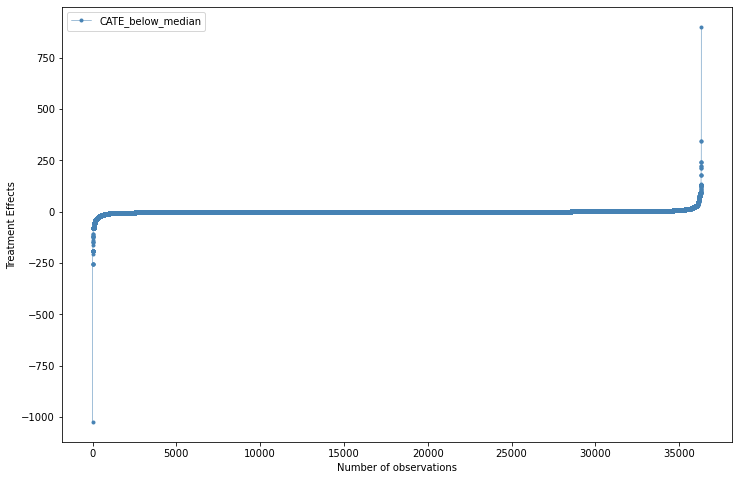

In [30]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_01['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_below_median', color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

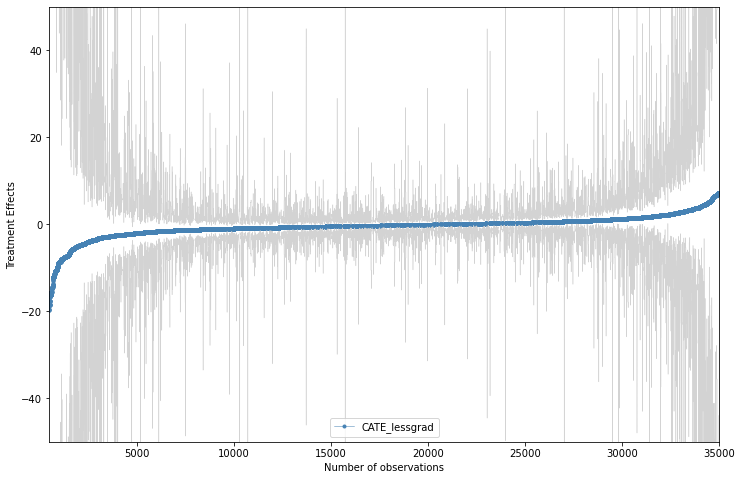

In [71]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_01['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_lessgrad', color='steelblue')
# uncomment for confidence intervals for peripheral neighbourhoods
ax.plot(df_te_01['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_01['ub'],linewidth=0.5, color='lightgrey')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 35000])
plt.ylim([-50,50])
plt.show()

In [147]:
df_te_01["cate"].median()

In [37]:
train_02, test_02 = train_test_split(sample02, test_size=0.2)

treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem", "total_incomed"]
instruments = ['same_sex']

Y_2 = train_02[outcome]
T_2 = train_02[treatment]
X_2 = train_02[covariates]
Z_2 = train_02[instruments]
X_test_2 = test_02[covariates]
W_2 = None

est_02 = CausalIVForest(criterion='het', 
                     n_estimators=500,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_02.fit(X_2, T_2, y=Y_2, Z=Z_2)

treatment_effects_02, lb_02, ub_02 = est_02.predict(X_2, interval=True, alpha=0.05)

te_02 = []

for i in range(len(treatment_effects_02)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_02[i][0]
    dict_te['lb'] = lb_02[i][0]
    dict_te['ub'] = ub_02[i][0]
    te_02.append(dict_te)
df_te_02 = pd.DataFrame(te_02)

df_te_02.sort_values('cate', inplace=True, ascending=True)
df_te_02.reset_index(inplace=True, drop=True)

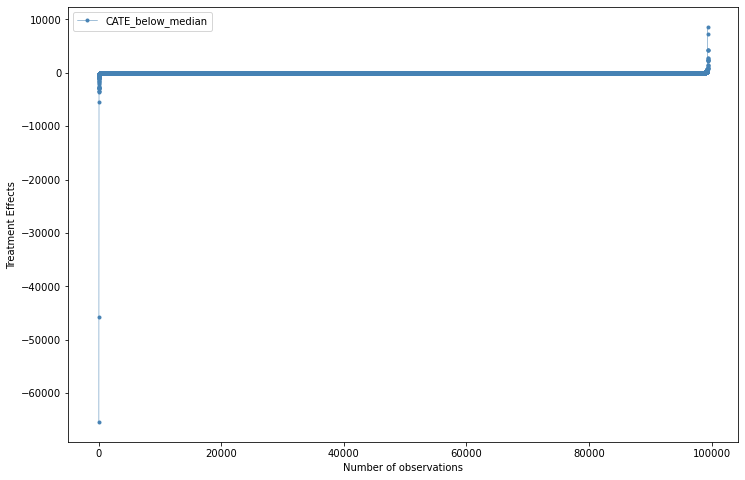

In [50]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_02['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_below_median', color='steelblue')

# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

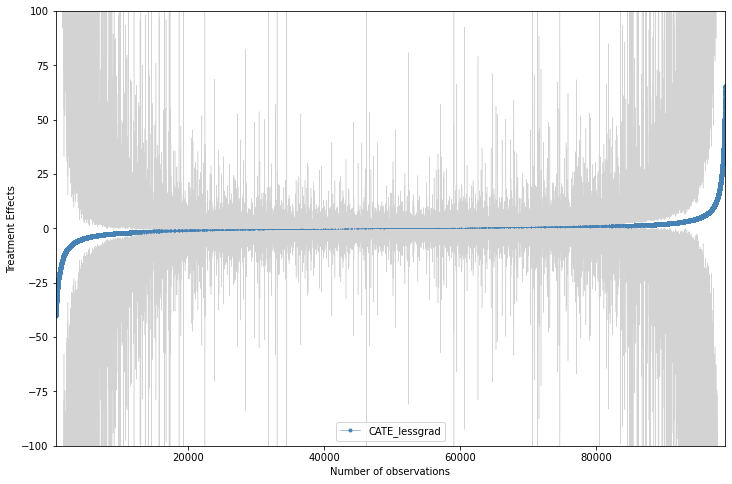

In [87]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_02['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_lessgrad', color='steelblue')
# uncomment for confidence intervals for peripheral neighbourhoods
ax.plot(df_te_02['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_02['ub'],linewidth=0.5, color='lightgrey')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 99000])
plt.ylim([-100,100])
plt.show()

In [144]:
df_te_02["cate"].median()

In [88]:
train_03, test_03 = train_test_split(sample03, test_size=0.2)

treatment = ['more2k']
outcome = ['workedm']
covariates = ["AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem", "total_incomed"]
instruments = ['same_sex']

Y_3 = train_03[outcome]
T_3 = train_03[treatment]
X_3 = train_03[covariates]
Z_3 = train_03[instruments]
X_test_3 = test_03[covariates]
W_3 = None

est_03 = CausalIVForest(criterion='het', 
                     n_estimators=500,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = True
                     )

est_03.fit(X_3, T_3, y=Y_3, Z=Z_3)

treatment_effects_03, lb_03, ub_03 = est_03.predict(X_3, interval=True, alpha=0.05)

te_03 = []

for i in range(len(treatment_effects_03)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_03[i][0]
    dict_te['lb'] = lb_03[i][0]
    dict_te['ub'] = ub_03[i][0]
    te_03.append(dict_te)
df_te_03 = pd.DataFrame(te_03)

df_te_03.sort_values('cate', inplace=True, ascending=True)
df_te_03.reset_index(inplace=True, drop=True)

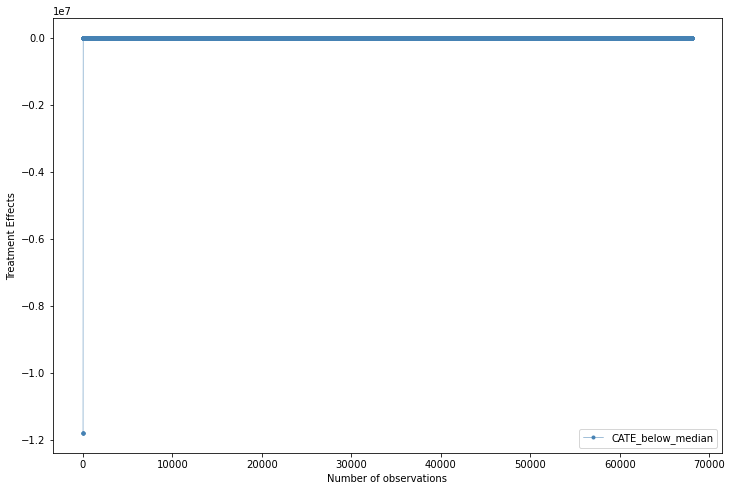

In [89]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_03['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_below_median', color='steelblue')

# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

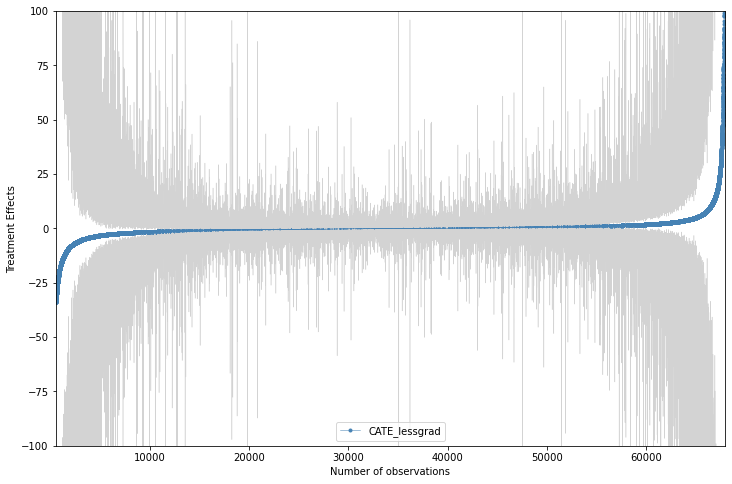

In [95]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(df_te_03['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_lessgrad', color='steelblue')
# uncomment for confidence intervals for peripheral neighbourhoods
ax.plot(df_te_03['lb'],linewidth=0.5, color='lightgrey')
ax.plot(df_te_03['ub'],linewidth=0.5, color='lightgrey')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()
plt.xlim([500, 68000])
plt.ylim([-100,100])
plt.show()

In [146]:
df_te_03["cate"].median()

**EXTENSION: MORE RESEARCH QUESTIONS**

Here I extended the 


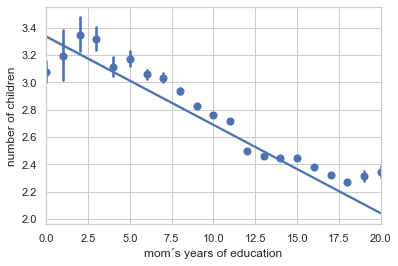

In [58]:
ax = sns.regplot(x="educm", y="KIDCOUNT", data=data_all_women_1980, x_estimator=np.mean)
ax.set(xlabel='mom´s years of education', ylabel='number of children')
plt.show()

There is a negative correlation between having more years of education and number of children.

In [98]:
def corr_OLS(data, outcome):
    Variables=["educm", "lessgrad", "moregrad"]
    table = pd.DataFrame(
        {
            "OLS (1)": [],
            "Std.err (1)": [],
            "P-value (1)": [],

        }
    )
    table["Variables"] = Variables
    table = table.set_index("Variables")
    table

    for variable in Variables:

        logit_mod=sm_api.Logit(data[outcome], data[[variable, "const", "AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]])
        logit_res = logit_mod.fit()


        outputs = [
                logit_res.params[variable],
                logit_res.bse[variable],
                logit_res.pvalues[variable],
        ]

        table.loc[variable] = outputs

    return table

In [99]:
Table_corr=corr_OLS(data_all_women_1980, "more2k")
Table_corr2=corr_OLS(msample_1980, "more2k")
Table_corr=pd.concat([Table_corr, Table_corr2], axis=1, keys=["All women 1980", "Married women 1980"])
Table_corr

Optimization terminated successfully.
         Current function value: 0.628738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626367
         Iterations 5


All women 1980                           Married women 1980  \
                 OLS (1) Std.err (1)   P-value (1)            OLS (1)   
Variables                                                               
educm          -0.082975    0.001616  0.000000e+00          -0.057024   
lessgrad        0.483975    0.008598  0.000000e+00           0.400238   
moregrad       -0.135484    0.008162  6.977460e-62          -0.008614   

                                      
          Std.err (1)    P-value (1)  
Variables                             
educm        0.001948  2.041775e-188  
lessgrad     0.011667  6.890744e-258  
moregrad     0.010018   3.898655e-01

In general, the education of moms has a negative relationship with number of children (coef educm)
Women with less than a highschool degree,have a bigger probability to have more children as women with higher educ.
If a woman belongs to the group of women who have more than a highshool degree, then the probability of having more than 2 children decreases.

**EXTENSION: TESTING FOR SELECTION ON UNOBSERVABLES OR VIOLATION OF EXCLUSION RESTRICTION**


In [22]:
sample_untreat_80=data_all_women_1980[data_all_women_1980["KIDCOUNT"]==2]
sample_treat_80=data_all_women_1980[data_all_women_1980["KIDCOUNT"]>2]

In [23]:
sample_untreat_m_80=msample_1980[msample_1980["KIDCOUNT"]==2]
sample_treat_m_80=msample_1980[msample_1980["KIDCOUNT"]>2]

In [24]:
#sample_treat_90=data_all_women_1990[data_all_women_1990["KIDCOUNT"]==2]
#sample_untreat_90=data_all_women_1990[data_all_women_1990["KIDCOUNT"]>2]#

In [ ]:
sample_untreat_m_90=msample_1990[msample_1990["KIDCOUNT"]==2]
sample_treat_m_90=msample_1990[msample_1990["KIDCOUNT"]>2]

In [55]:
sample_untreat_80_t=data_all_women_1980[(data_all_women_1980["KIDCOUNT"]==2) & (data_all_women_1980["twins"]==0)]
sample_treat_80_t=data_all_women_1980[(data_all_women_1980["KIDCOUNT"]>2)]

In [30]:
sample_untreat_80_m_t=msample_1980[(msample_1980["KIDCOUNT"]==2) & (msample_1980["twins"]==0)]
sample_treat_80_m_t=msample_1980[(msample_1980["KIDCOUNT"]>2) & (msample_1980["twins"]==1)]

In [79]:
def CIA_Test(data, data2, instrument):

    table = pd.DataFrame(
        {
            "OLS (Y_0)": [],
            "P-Value (Y_0)": [],
            "OLS (Y_1)": [],
            "P-value (Y_1)": [],
        }
    )
    outcomes=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:

        data=data
        model_OLS_Y0=sm_api.OLS(data[outcome], sm_api.add_constant(data[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y0=model_OLS_Y0.fit()
        model_OLS_Y1=sm_api.OLS(data2[outcome], sm_api.add_constant(data2[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y1=model_OLS_Y1.fit()        
        
        outputs = [
                result_OLS_Y0.params[instrument],
                result_OLS_Y0.pvalues[instrument],
                result_OLS_Y1.params[instrument],
                result_OLS_Y1.pvalues[instrument],
        ]
        
        table.loc[outcome] = outputs
        table = table.round(4)

    return table

In [95]:
Table_CIAtest_1=CIA_Test(sample_treat_80, sample_untreat_80, "same_sex")
Table_CIAtest_2=CIA_Test(sample_treat_m_80, sample_untreat_m_80, "same_sex")
Table_CIAtest_3=CIA_Test(sample_treat_80_t, sample_untreat_80_t, "twins")
Table_CIAtest_4=CIA_Test(sample_treat_80_m_t, sample_untreat_80_m_t, "twins")
Table_CIAtest_1980=pd.concat([Table_CIAtest_1, Table_CIAtest_2, Table_CIAtest_3, Table_CIAtest_4], axis=1, 
                             keys=["All women-same sex", "Married women-same sex", "All women-twins", 
                                   "Married women-twins"])

In [96]:
Table_CIAtest_1980

All women-same sex                                        \
                       OLS (Y_0) P-Value (Y_0) OLS (Y_1) P-value (Y_1)   
outcomes                                                                 
workedm                   0.0047        0.0174    0.0020        0.4241   
WEEKSM                    0.2992        0.0009    0.0684        0.5114   
HOURSM                    0.2061        0.0062    0.0060        0.9485   
total_incomem           188.5705        0.0000   -0.6626        0.9890   
faminc_log                0.0018        0.7180    0.0131        0.0664   
nonmomi_log              -0.0207        0.0359    0.0170        0.1296   

              Married women-same sex                                        \
                           OLS (Y_0) P-Value (Y_0) OLS (Y_1) P-value (Y_1)   
outcomes                                                                     
workedm                       0.0042        0.0866    0.0021        0.5129   
WEEKSM                        0.2522        0.0210    0.0876        0.5006   
HOURSM                        0.1310        0.1460   -0.0024        0.9831   
total_incomem               175.4067        0.0009   53.7750        0.3549   
faminc_log                   -0.0003        0.9569    0.0177        0.0163   
nonmomi_log                  -0.0013        0.8301    0.0196        0.0215   

              All women-twins                                         \
                    OLS (Y_0) P-Value (Y_0)  OLS (Y_1) P-value (Y_1)   
outcomes                                                               
workedm                   0.0           0.0     0.1940        0.0209   
WEEKSM                    0.0           0.0    -4.6868        0.1972   
HOURSM                    0.0           0.0     8.0982        0.0086   
total_incomem            -0.0           0.0 -7645.1261        0.0000   
faminc_log                0.0           0.0     8.3537        0.0000   
nonmomi_log               0.0           0.0     7.6630        0.0000   

              Married women-twins                                         
                        OLS (Y_0) P-Value (Y_0)  OLS (Y_1) P-value (Y_1)  
outcomes                                                                  
workedm                       0.0           0.0     0.2045        0.0657  
WEEKSM                        0.0           0.0    -3.0319        0.5160  
HOURSM                        0.0           0.0     8.3383        0.0318  
total_incomem                -0.0           0.0 -5270.4308        0.0124  
faminc_log                    0.0           0.0     8.9433        0.0000  
nonmomi_log                   0.0           0.0     8.8957        0.0000

In [43]:
def CIA_Test_husbands(data, data2, instrument):

    table = pd.DataFrame(
        {
            "OLS (Y_0)": [],
            "P-Value (Y_0)": [],
            "OLS (Y_1)": [],
            "P-value (Y_1)": [],
        }
    )
    outcomes=["workedd", "WEEKSD", "HOURSD", "total_incomed"]
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:

        data=data
        model_OLS_Y0=sm_api.OLS(data[outcome], sm_api.add_constant(data[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y0=model_OLS_Y0.fit()
        model_OLS_Y1=sm_api.OLS(data2[outcome], sm_api.add_constant(data2[[instrument, "boy1st", "boy2nd", "AGEM", 'agefstm', "blackm", "hispm", "otheracem"]]))
        result_OLS_Y1=model_OLS_Y1.fit()        
        
        outputs = [
                result_OLS_Y0.params[instrument],
                result_OLS_Y0.pvalues[instrument],
                result_OLS_Y1.params[instrument],
                result_OLS_Y1.pvalues[instrument],
        ]
        
        table.loc[outcome] = outputs
        table = table.round(4)

    return table

In [48]:
Table_CIAtest_2=CIA_Test_husbands(sample_treat_m_80, sample_untreat_m_80, "same_sex")
Table_CIAtest_2

,OLS (Y_0),P-Value (Y_0),OLS (Y_1),P-value (Y_1)
outcomes,,,,
workedd,0.0006,0.5806,0.0009,0.1775
WEEKSD,0.1812,0.0131,0.0396,0.4190
HOURSD,-0.0985,0.2462,0.0911,0.1182
total_incomed,190.5172,0.2278,-148.6869,0.2121


In [49]:
Table_CIAtest_2=CIA_Test_husbands(sample_treat_m_80, sample_untreat_m_80, "twins")
Table_CIAtest_2

,OLS (Y_0),P-Value (Y_0),OLS (Y_1),P-value (Y_1)
outcomes,,,,
workedd,0.0018,0.6241,0.0,0.0
WEEKSD,0.0161,0.9484,0.0,0.0
HOURSD,-0.6535,0.0238,0.0,0.0
total_incomed,307.4445,0.5676,-0.0,0.0


**TO ADD IN AUX**



In [6]:
#data=data_all_women_1980
#data["educm"]=np.maximum(0, data.educm)

## Apendix: Dictionary of key variables 

#### data_2

| **Name**        | **Description**                            |
|-----------------|--------------------------------------------|
| **index**       |                                            |
| byr             | birth year                                 |
| race            | ethnicity, 1 for white and 2 for nonwhite  |
| interval        | interval of draft lottery numbers, 73 intervals with the size of five consecutive numbers        |
| year            | year for which earnings are collected      |
| **variables**   |                                            |
| vmn1            | nominal earnings                           |
| vfin1           | fraction of people with zero earnings      |
| vnu1            | sample size                                |
| vsd1            | standard deviation of earnings             |

-------
Notebook by Carolina Alvarez | GitHub profile: https://github.com/carolinalvarez.

---

# References 

* **Angrist, J., & Evans, W. (1998)**. *Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size*, 88(3), The American Economic Review.

